In [1]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [2]:
# 혹 다른 데이터 셋 추가(Pretrained Model Weights)로 인해 PATH가 변경된다면 아래 PATH를 수정
DATA_PATH = '../input/'
os.listdir(DATA_PATH)

['3rd-ml-month-car-image-cropping-dataset', '2019-3rd-ml-month-with-kakr']

In [3]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH,'3rd-ml-month-car-image-cropping-dataset/train_crop')
TEST_IMG_PATH = os.path.join(DATA_PATH, '3rd-ml-month-car-image-cropping-dataset/test_crop')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, '2019-3rd-ml-month-with-kakr/train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, '2019-3rd-ml-month-with-kakr/test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, '2019-3rd-ml-month-with-kakr/class.csv'))

In [4]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


In [5]:
from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(7992, 2)
(1998, 2)
(6150, 1)


In [6]:
# from keras.applications.resnet50 import ResNet50, preprocess_input
# from keras.applications.densenet import DenseNet201, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (448, 448)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 16

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True, 
    vertical_flip = False,
    zoom_range=0.10,
    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory='../input/3rd-ml-month-car-image-cropping-dataset/train_crop/',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory='../input/3rd-ml-month-car-image-cropping-dataset/train_crop',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='../input/3rd-ml-month-car-image-cropping-dataset/test_crop',
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 7992 validated image filenames belonging to 196 classes.
Found 1998 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


In [7]:
inceptionV3_model = InceptionV3(include_top=False, input_shape = (448,448,3))
inceptionV3_model.summary()

87916544/87910968 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 223, 223, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 223, 223, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 223, 223, 32) 0           batch_normalization_1[0][0]      
____________________________________________

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

model = Sequential()
model.add(inceptionV3_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 12, 12, 2048)      21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               200900    
Total params: 24,101,860
Trainable params: 24,067,428
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
from sklearn.metrics import f1_score
from keras.optimizers import SGD

def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['acc'])

In [10]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [11]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

filepath = "my_densenet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
# logfilename = "densenet_model" + "-log.csv"
# csvlogger = CSVLogger(logfilename, separator=',', append=True)

# callbacksList = [es, csvlogger] 
callbackList = [es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList
)
gc.collect()

Epoch 1/20
500/500 [==============================] - 413s 826ms/step - loss: 5.2865 - acc: 0.0065 - val_loss: 5.2406 - val_acc: 0.0115
Epoch 2/20
500/500 [==============================] - 384s 767ms/step - loss: 4.9519 - acc: 0.0205 - val_loss: 4.5557 - val_acc: 0.0440
Epoch 3/20
500/500 [==============================] - 381s 763ms/step - loss: 3.7602 - acc: 0.1284 - val_loss: 2.9545 - val_acc: 0.2142
Epoch 4/20
500/500 [==============================] - 381s 763ms/step - loss: 2.4160 - acc: 0.3495 - val_loss: 2.2131 - val_acc: 0.4029
Epoch 5/20
500/500 [==============================] - 382s 763ms/step - loss: 1.6433 - acc: 0.5304 - val_loss: 1.5715 - val_acc: 0.5385
Epoch 6/20
500/500 [==============================] - 382s 765ms/step - loss: 1.2116 - acc: 0.6402 - val_loss: 1.1479 - val_acc: 0.6637
Epoch 7/20
500/500 [==============================] - 381s 762ms/step - loss: 0.8921 - acc: 0.7325 - val_loss: 1.7594 - val_acc: 0.5841
Epoch 8/20
500/500 [============================

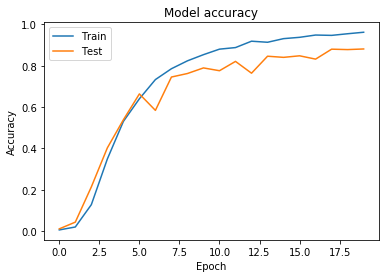

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

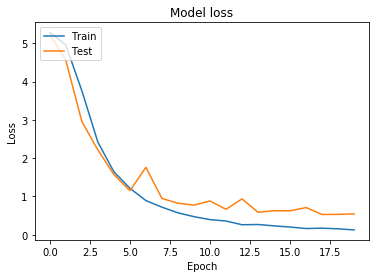

In [13]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
%%time
test_generator.reset()
prediction = model.predict_generator(
    generator = test_generator,
    steps = get_steps(nb_test_samples, batch_size),
    verbose=1
)

385/385 [==============================] - 67s 175ms/step
CPU times: user 1min 1s, sys: 41.2 s, total: 1min 42s
Wall time: 1min 7s


In [15]:
predicted_class_indices=np.argmax(prediction, axis=1)

# Generator class dictionary mapping
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

submission = pd.read_csv(os.path.join(DATA_PATH, './2019-3rd-ml-month-with-kakr/sample_submission.csv'))
submission["class"] = predictions
submission.to_csv("submission.csv", index=False)
submission.head()

,img_file,class
0,test_00001.jpg,124
1,test_00002.jpg,98
2,test_00003.jpg,157
3,test_00004.jpg,94
4,test_00005.jpg,16
